In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from langchain.chat_models import init_chat_model
os.environ['TAVILY_API_KEY']=os.getenv('TAVILY_API_KEY')
os.environ['OPENAI_API_KEY']=os.getenv('OPENAI_API_KEY')
os.environ['GROQ_API_KEY']=os.getenv('GROQ_API_KEY')

In [5]:
llm=init_chat_model('groq:gemma2-9b-it')

from typing import Annotated
from langchain_core import tools
from langchain.tools import WikipediaQueryRun
from langchain.utilities import WikipediaAPIWrapper
from langchain_tavily import TavilySearch

In [7]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import TextLoader
from langchain.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings

In [28]:
from langchain.agents import Tool
tavily_tool=TavilySearch(max_results=5)

def make_retriever_tool_from_text(file,name,desc):
    docs=TextLoader(file,encoding='utf-8').load()
    chunks=RecursiveCharacterTextSplitter(chunk_size=500,chunk_overlap=100).split_documents(docs)
    vector_store=FAISS.from_documents(chunks,OpenAIEmbeddings(model='text-embedding-3-small'))
    retriever=vector_store.as_retriever()

    def tool_func(query:str) -> str:
        print(f"Using tool: {name}")
        results=retriever.get_relevant_documents(query)[:3]
        return "\n\n".join(doc.page_content for doc in results)
    
    return Tool(name=name,description=desc,func=tool_func)

internal_tool_1=make_retriever_tool_from_text('research_notes.txt','InternalResearchNotes','Search internal research notes for experimental results')


internal_tool_1

Tool(name='InternalResearchNotes', description='Search internal research notes for experimental results', func=<function make_retriever_tool_from_text.<locals>.tool_func at 0x7f227165a8e0>)

In [41]:
from langchain_core.messages import BaseMessage,HumanMessage
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState,END
from langgraph.types import Command


def get_next_node(last_message:BaseMessage,goto:str):
    if 'FINAL ANSWER' in last_message.content:
        return END
    return goto

In [42]:
def make_system_prompt(suffix:str)->str:
    return (
        "You are a helpful AI assistant,collaborating with other assistants."
        "Use the provided tools to progress towards answering the question."
        "If you are unable to fully answer,thats OK,another assistant with different tools."
        "will help where you left off.Execute what you can do to make progress."
        "If you or any of the other assistants have the final answer or deliverable."
        "prefix your response with FINAL ANSWER so the team knows how to stop."
        f"\n{suffix}"
    )

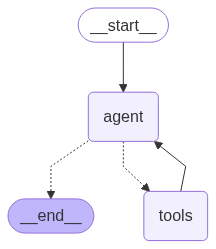

In [43]:
research_agent=create_react_agent(llm,
                                  tools=[internal_tool_1,tavily_tool],
                                  prompt=make_system_prompt("You can only do research,Use the tool that you are binded with,you can use both of them"\
                                                            "You are working with a content writer colleague."))

research_agent

In [44]:
from typing import Literal

In [45]:
def research_node(state:MessagesState)->Command[Literal['blog_generator',END]]:
    result=research_agent.invoke(state)
    goto=get_next_node(result['messages'][-1],'blog_generator')

    # wrap in a human message,as not all providers allow
    # AI message at the last position of the input messages list
    result['messages'][-1]=HumanMessage(
        content=result['messages'][-1].content,name='researcher'
    )
    
    return Command(
        update={
            'messages':result['messages'],
        },
        goto=goto,
    )

In [46]:
blog_agent=create_react_agent(
    llm,tools=[],
    prompt=make_system_prompt(
        "you can only write a detailed blog. You are working with a researcher colleague."
    )
)

def blog_node(state:MessagesState)->Command[Literal['researcher',END]]:
    result=blog_agent.invoke(state)
    goto=get_next_node(result['messages'][-1],'researcher')

    # wrap in a human message,as not all providers allow
    # AI message at the last position of the input messages list
    result['messages'][-1]=HumanMessage(
        content=result['messages'][-1].content,name='blog_generator'
    )
    
    return Command(
        update={
            'messages':result['messages'],
        },
        goto=goto,
    )


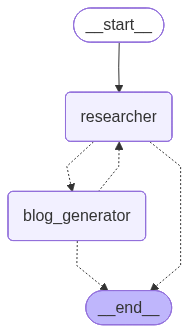

In [50]:
from langgraph.graph import StateGraph,START

workflow=StateGraph(MessagesState)
workflow.add_node('researcher',research_node)
workflow.add_node('blog_generator',blog_node)

workflow.add_edge(START,'researcher')
graph=workflow.compile()
graph

##### SupervisorAgent

In [51]:
from langchain_tavily import TavilySearch
web_search=TavilySearch(max_results=3)
web_search

TavilySearch(max_results=3, api_wrapper=TavilySearchAPIWrapper(tavily_api_key=SecretStr('**********'), api_base_url=None))

In [52]:
internal_tool_1

Tool(name='InternalResearchNotes', description='Search internal research notes for experimental results', func=<function make_retriever_tool_from_text.<locals>.tool_func at 0x7f227165a8e0>)

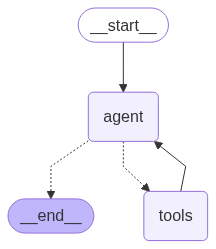

In [53]:
from langgraph.prebuilt import create_react_agent
research_agent=create_react_agent(
    model=llm,
    tools=[web_search,internal_tool_1],
    prompt=(
        "You are a research agent.\n\n"
        "INSTRCUTION:\n"
        "- Assist ONLY with research-related tasks,DO NOT do any math\n"
        "-After you're done with your tasks,respond to the supervisor directly\n"
        "-Respond ONLY with the results of your work,do NOT include ANY other text."
    ),
    name="research_agent"
)
research_agent

In [54]:
def add(a:float,b:float):
    """Add two numbers."""
    return a+b

def multiply(a:float,b:float):
    """Multiply two numbers"""
    return a*b

def divide(a:float,b:float):
    """Divide two numbers."""
    return a/b

In [58]:
math_agent=create_react_agent(
    model=llm,
    tools=[add,multiply,divide],
    prompt=("You are a math agent.\n\n"
    "INSTRUCTION:\n"
    "- Assist ONLY with math-related tasks\n"
    "- After you're done with your tasks,respond to the supervisor directly\n"
    "- Respond ONLY with the results of your work,do NOT include ANY other text."),
    name="math_agent"
)

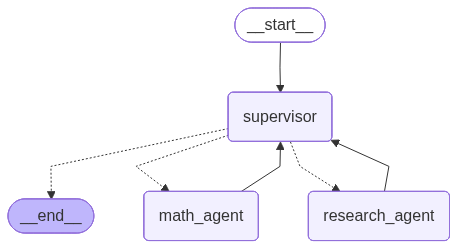

In [60]:
from langgraph_supervisor import create_supervisor
supervisor=create_supervisor(
    model=llm,agents=[research_agent,math_agent],
    prompt=(
        "You are a supervisor managing two agents:\n"
        "- a research agent. Assign research-related tasks to this agent\n"
        "- a math agent. Assign math-related tasks to this agent\n"
        "Assign work to one agent at a time,do not call agents in parallel.\n"
        "Do not do any work yourself"
    ),
    add_handoff_back_messages=True,
    output_mode="full_history"

).compile()

supervisor

In [67]:
response=supervisor.invoke({'messages':"Get the information about attention mechanism from retriever and then also do additional browse search to get additional info about'attention mechansim'"})

In [68]:
response

{'messages': [HumanMessage(content="Get the information about attention mechanism from retriever and then also do additional browse search to get additional info about'attention mechansim'", additional_kwargs={}, response_metadata={}, id='012606cf-c073-4b92-a507-30cd3327f202'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'arbf29mks', 'function': {'arguments': '{}', 'name': 'transfer_to_research_agent'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 78, 'prompt_tokens': 1073, 'total_tokens': 1151, 'completion_time': 0.141818182, 'prompt_time': 0.020311049, 'queue_time': 0.25190908, 'total_time': 0.162129231}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, name='supervisor', id='run--b3787faf-a436-43ad-a750-48d34bb2dd18-0', tool_calls=[{'name': 'transfer_to_research_agent', 'args': {}, 'id': 'arbf29mks', 'type': 'tool_call'}], usage_me

##### HierarichalAgenticRag

In [69]:
from typing import Annotated,List
from langchain_community.document_loaders import WebBaseLoader
from langchain_tavily import TavilySearch
from langchain_core.tools import tool

tavily_tool=TavilySearch(max_results=5)

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [70]:
@tool
def scrap_webpages(urls:List[str])->str:
    """Use requests and bs4 to scrape the provided web pages for detailed information."""
    loader=WebBaseLoader(urls)
    docs=loader.load()
    return "\n\n".join(
        [
            f'<Document name="{doc.metadata.get("title","")}>\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )

In [71]:
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import Dict,Optional

from langchain_experimental.utilities import PythonREPL
from typing_extensions import TypedDict

_TEMP_DIRECTORY=TemporaryDirectory()
WORKING_DIRECTORY=Path(_TEMP_DIRECTORY.name)

@tool
def create_outline(
    points:Annotated[List[str],"List of main points or sections."],
    file_name:Annotated[str,"File path to save the outline."]
)->Annotated[str,"Path of the saved outline file."]:
    """Create and save an outline."""
    with(WORKING_DIRECTORY/file_name).open('w') as file:
        for i,point in enumerate(points):
            file.write(f"{i+1}.{point}\n")
    return f"Outline saved to {file_name}"
    

@tool
def write_document(
    content:Annotated[List[str],"Text content to be written into the document."],
    file_name:Annotated[str,"File path to save the document."]
)->Annotated[str,"Path of the saved document file."]:
    """Create and save a text document."""
    with(WORKING_DIRECTORY/file_name).open('w') as file:
            file.write(content)
    return f"Document saved to {file_name}"


@tool
def edit_document(
    file_name:Annotated[str,"Path of the document to be edited."],
    inserts:Annotated[Dict[int,str],"Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",]
)->Annotated[str,"Path of the edited document file."]:
    """Edit a document by inserting text at specific line numbers"""
    with(WORKING_DIRECTORY/file_name).open('r') as file:
            lines=file.readlines()
    
    sorted_inserts=sorted(inserts.items())

    for line_number,text in sorted_inserts:
        if 1 <=line_number <= len(lines) + 1:
              lines.insert(line_number-1,text+'\n')
        else:
             return f"Error: Line number {line_number} is out of range."
        
    with (WORKING_DIRECTORY/file_name).open('w') as file:
         file.writelines(lines)

    return f'Document edited and saved to {file_name}'


In [72]:
repl=PythonREPL()

@tool
def python_repl_tool(
    code:Annotated[str,"the python code to execute to generate your chart."],
):
    """Use this to execute python code.if you want to see the output of a value,
    you should print it out with 'print()', This is visible to the user."""
    try:
        result=repl.run(code)
    except BaseException as e:
        return f"failed to execute.Error:{repr(e)}"
    return f"successfully executed:\n ```python\n{code}\n```\nStdout: {result}"

In [73]:
from typing import List,Optional,Literal
from langchain_core.language_models.chat_models import BaseChatModel

from langgraph.graph import StateGraph,MessagesState,START,END
from langgraph.types import Command
from langchain_core.messages import HumanMessage,trim_messages

class State(MessagesState):
    next:str

In [74]:
def make_supervisor_node(llm:BaseChatModel,members:List[str])->str:
    options=['FINISH'] + members
    system_prompt=(
        "You are a supervisor tasked with managing a conversation between the"
        f"following workers: {members}.Given the following user request,"
        "respond with worker to act next,Each worker will perform a"
        "task and respond with their results and status.when finished"
        "respond with FINISH"
    )

    class Router(TypedDict):
        """Worker to route to next,if no workers needed,route to FINISH."""
        next:Literal[*options]

    def supervisor_node(state:State) -> Command[Literal[*members,"__end__"]]:
        """An LLM-based router."""
        messages=[
            {'role':'system','context':system_prompt},
        ] + state['messages']
        response=llm.with_structured_output(Router).invoke(messages)
        goto=response['next']
        if goto=='FINISH':
            goto=END

        return Command(goto=goto,update={'next':goto})
    return supervisor_node

In [75]:
internal_tool_1

Tool(name='InternalResearchNotes', description='Search internal research notes for experimental results', func=<function make_retriever_tool_from_text.<locals>.tool_func at 0x7f227165a8e0>)

In [78]:
from langchain_core.messages import HumanMessage
from langchain.chat_models import init_chat_model
from langgraph.prebuilt import create_react_agent

search_agent=create_react_agent(llm,tools=[tavily_tool,internal_tool_1])


def search_node(state:State) -> Command[Literal['supervisor']]:
    result=search_agent.invoke(state)
    return Command(
        update={
            'messages':[
                HumanMessage(content=result['messages'][-1].content,name='search')
            ]
        },
        # we want our workers to ALWAYS 'report back' to the supervisor when done
        goto='supervisor',
    )

def web_scraper_node(state:State) -> Command[Literal['supervisor']]:
    result=search_agent.invoke(state)
    return Command(
        update={
            'messages':[
                HumanMessage(content=result['messages'][-1].content,name='web_scraper')
            ]
        },
        # we want our workers to ALWAYS 'report back' to the supervisor when done
        goto='supervisor',
    )



In [79]:
research_supervisor_node=make_supervisor_node(llm,['search','web_scraper'])

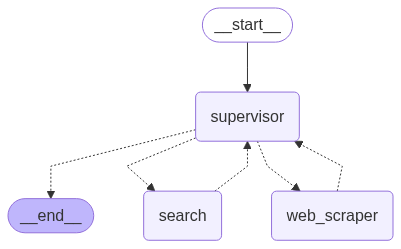

In [80]:
research_builder=StateGraph(State)
research_builder.add_node('supervisor',research_supervisor_node)
research_builder.add_node('search',search_node)
research_builder.add_node('web_scraper',web_scraper_node)

research_builder.add_edge(START,'supervisor')
research_graph=research_builder.compile()
research_graph

In [81]:
@tool
def read_document(
    file_name:Annotated[str,"File path to read the document from."],
    start:Annotated[Optional[int],"The start line,Default is 0."]=None,
    end:Annotated[Optional[int],"The end line,Default is None"]=None,
)->str:
    """Read the specified document"""
    with(WORKING_DIRECTORY/file_name).open('r') as file:
            lines=file.readlines()
    
    if start is None:
          start=0
    return "\n".join(lines[start:end])


In [ ]:
doc_writer_agent=create_react_agent(
    llm,
    tools=[write_document,edit_document,read_document],
    prompt=(
        "You can read,write and edit documents based on note-taker's outlines."
        "Dont ask follow-up questions."
    ),
)

def search_node(state:State) -> Command[Literal['supervisor']]:
    result=search_agent.invoke(state)
    return Command(
        update={
            'messages':[
                HumanMessage(content=result['messages'][-1].content,name='search')
            ]
        },
        # we want our workers to ALWAYS 'report back' to the supervisor when done
        goto='supervisor',
    )

def doc_writing_node(state:State) -> Command[Literal['supervisor']]:
    result=doc_writer_agent.invoke(state)
    return Command(
        update={
            'messages':[
                HumanMessage(content=result['messages'][-1].content,name='doc_writer')
            ]
        },
        # we want our workers to ALWAYS 'report back' to the supervisor when done
        goto='supervisor',
    )

In [83]:
doc_writer_agent=create_react_agent(
    llm,
    tools=[create_outline,read_document],
    prompt=(
        "You can read,documents and create outlines for the document writer."
        "Dont ask follow-up questions."
    ),
)


def note_taking_node(state:State) -> Command[Literal['supervisor']]:
    result=search_agent.invoke(state)
    return Command(
        update={
            'messages':[
                HumanMessage(content=result['messages'][-1].content,name='note_taker')
            ]
        },
        # we want our workers to ALWAYS 'report back' to the supervisor when done
        goto='supervisor',
    )


In [84]:
chart_generating_node=create_react_agent(
    llm,
    tools=[python_repl_tool,read_document],
    
)


def chart_generating_node(state:State) -> Command[Literal['supervisor']]:
    result=search_agent.invoke(state)
    return Command(
        update={
            'messages':[
                HumanMessage(content=result['messages'][-1].content,name='chart_generator')
            ]
        },
        # we want our workers to ALWAYS 'report back' to the supervisor when done
        goto='supervisor',
    )


In [85]:
doc_writing_supervisor_node=make_supervisor_node(
    llm,['doc_writer','note_taker','chart_generator']
)

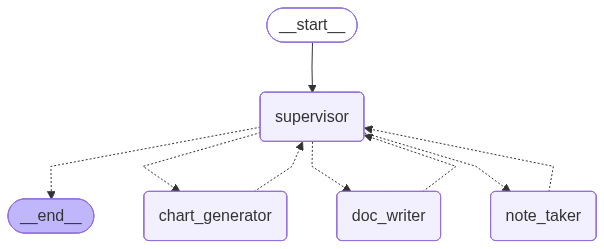

In [86]:
paper_writing_builder=StateGraph(State)
paper_writing_builder.add_node('supervisor',doc_writing_supervisor_node)
paper_writing_builder.add_node('doc_writer',doc_writing_node)
paper_writing_builder.add_node('note_taker',note_taking_node)
paper_writing_builder.add_node('chart_generator',chart_generating_node)
paper_writing_builder.add_edge(START,'supervisor')


research_graph=paper_writing_builder.compile()
research_graph

In [87]:
from langchain_core.messages import BaseMessage
teams_supervisor_node=make_supervisor_node(llm,['research_team','writing_team'])
teams_supervisor_node

<function __main__.make_supervisor_node.<locals>.supervisor_node(state: __main__.State) -> langgraph.types.Command[typing.Literal['research_team', 'writing_team', '__end__']]>

In [88]:
def call_research_team(state:State) -> Command[Literal['supervisor']]:
    result=search_agent.invoke(state)
    return Command(
        update={
            'messages':[
                HumanMessage(content=result['messages'][-1].content,name='research_team')
            ]
        },
        
        goto='supervisor',
    )

def call_paper_writing_node(state:State) -> Command[Literal['supervisor']]:
    result=doc_writer_agent.invoke(state)
    return Command(
        update={
            'messages':[
                HumanMessage(content=result['messages'][-1].content,name='writing_team')
            ]
        },
        # we want our workers to ALWAYS 'report back' to the supervisor when done
        goto='supervisor',
    )

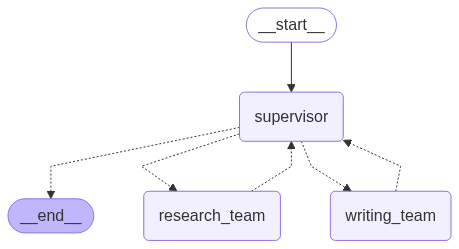

In [90]:
super_builder=StateGraph(State)
super_builder.add_node('supervisor',teams_supervisor_node)
super_builder.add_node('research_team',call_research_team)
super_builder.add_node('writing_team',call_paper_writing_node)

super_builder.add_edge(START,'supervisor')


super_graph=super_builder.compile()
super_graph